# RoBERTa-large
https://huggingface.co/FacebookAI/xlm-roberta-base

In [1]:
!nvidia-smi

Mon Mar  3 18:31:49 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:C2:00.0 Off |                   On |
| N/A   33C    P0              63W / 300W |  15218MiB / 81920MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [2]:
%pip install transformers 
%pip install datasets 
%pip install torch 
%pip install scikit-learn
%pip install pandas
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import ast
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from typing import Dict, Any, List
from datetime import datetime
import pickle
import seaborn as sns


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
MODEL_DIR = "/vol/bitbucket/rk1121/nlp/models"
raw_dir = f"{MODEL_DIR}/raw"
basic_finetuned_dir = f"{MODEL_DIR}/basic_finetuned"
weighted_loss_dir = f"{MODEL_DIR}/weighted_loss"
weighted_sampler_dir = f"{MODEL_DIR}/weighted_sampler"
weighted_loss_sampler_dir = f"{MODEL_DIR}/weighted_loss_sampler"
augmented_dir = f"{MODEL_DIR}/augmented"
combined_dir = f"{MODEL_DIR}/combined"
optimal_dir = f"{MODEL_DIR}/optimal"
final_dir = f"{MODEL_DIR}/final"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load RoBERTa-large

In [4]:
MODEL_NAME = "roberta-large"
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [5]:
# Load tokenizer and model
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) 

model.to(device)
model.save_pretrained(raw_dir)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load raw text data

In [5]:
def convert_to_binary(label: Any) -> int:
    """
    Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
    """
    # If label_array is a string, convert it to a list
    return 0 if label == 0 or label == 1 else 1 

In [6]:
TRAIN_DATA_PATH = "data/dontpatronizeme_pcl.tsv"
TRAIN_ALLOC_PATH = "data/train_semeval_parids-labels.csv"
DEV_ALLOC_PATH = "data/dev_semeval_parids-labels.csv"

column_names = ["par_id", "art_id", "keyword", "country", "text", "orig_label"]
text_data = pd.read_csv(TRAIN_DATA_PATH, sep="\t", header=None, names=column_names)
text_data["label"] = text_data["orig_label"].apply(convert_to_binary)

print("Text Data shape:", text_data.shape)

train_alloc = pd.read_csv(TRAIN_ALLOC_PATH).drop("label", axis=1)
official_dev_alloc = pd.read_csv(DEV_ALLOC_PATH).drop("label", axis=1)
print("Train Allocation shape:", train_alloc.shape)
print("Official Dev Allocation shape:", official_dev_alloc.shape)

train_data = pd.merge(train_alloc, text_data, on="par_id")
official_dev_data = pd.merge(official_dev_alloc, text_data, on="par_id")
print("Merged Train Data shape:", train_data.shape)
print("Merged Official Dev Data shape:", official_dev_data.shape)

Text Data shape: (10469, 7)
Train Allocation shape: (8375, 1)
Official Dev Allocation shape: (2094, 1)
Merged Train Data shape: (8375, 7)
Merged Official Dev Data shape: (2094, 7)


### (Pre-)Tokenize Dataset

In [7]:
def tokenize(text, tokenizer, max_length=128):
  return tokenizer(
    str(text),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
  )

In [8]:
pretokenized_data = []
for index, row in train_data.iterrows():
  tokenized = tokenize(row["text"], tokenizer)
  tokenized = { key : value.squeeze(0).clone() for key, value in tokenized.items() }
  tokenized["labels"] = row["label"]
  tokenized["text"] = row["text"]
  pretokenized_data.append(tokenized)

with open("pretokenized.pkl", "wb") as f:
  pickle.dump(pretokenized_data, f)

### Load into DataLoader's

In [8]:
class DontPatronizeMeDataset(Dataset):
  def __init__(self, data, tokenizer = None, max_length=128, has_label=True):
    self.tokenizer = tokenizer

    self.has_label = has_label

    if self.tokenizer is not None:
      self.max_length = max_length
      self.data = data.reset_index(drop = True)
    else:
      self.data = data

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
    if self.tokenizer is not None:
      text = str(self.data.loc[idx, "text"])
      
      if self.has_label:
        label = self.data.loc[idx, "label"]

      encoding = self.tokenizer(
        text, 
        add_special_tokens=True,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
      )

      encoding = { key: value.squeeze(0) for key, value in encoding.items() }
      
      if self.has_label:
        encoding["labels"] = torch.tensor(label, dtype=torch.long)

      return encoding
    else:
      item = self.data[idx]
      item.pop("text", None)
      return item


In [9]:
with open("pretokenized.pkl", "rb") as f:
  pretokenized_data = pickle.load(f)

labels = [int(item["labels"]) for item in pretokenized_data]

internal_train_data, internal_test_data = train_test_split(
  pretokenized_data,
  test_size = 0.2,
  random_state = 16,
  stratify=labels
)

train_dataset = DontPatronizeMeDataset(internal_train_data)
test_dataset = DontPatronizeMeDataset(internal_test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

## Data Visualisation

### See if there is class imabalance

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

def visualise_imbalance(train_data, test_data, with_aug=False):
  train_labels = [int(item["labels"]) for item in train_data]
  test_labels = [int(item["labels"]) for item in test_data]

  train_counts = Counter(train_labels)
  test_counts = Counter(test_labels)

  train_sorted = { k : v for k, v in sorted(train_counts.items()) }
  test_sorted = { k : v for k, v in sorted(test_counts.items()) }

  print("--- Train ---")
  print(train_sorted)
  train_total = sum(train_counts.values())
  print({ k: f"{(100 * v / train_total):.2f}%" for k, v in train_sorted.items() })

  print("--- Test ---")
  print(test_sorted)
  test_total = sum(test_counts.values())
  print({ k: f"{(100 * v / test_total):.2f}%" for k, v in test_sorted.items() })

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

  axes[0].bar(list(train_sorted.keys()), list(train_sorted.values()), color='skyblue')
  axes[0].set_title(f'Train Data Label Distribution {"(with Data Augmentation)" if with_aug else ""}')
  axes[0].set_xlabel('Label')
  axes[0].set_ylabel('Count')

  axes[1].bar(list(test_sorted.keys()), list(test_sorted.values()), color='salmon')
  axes[1].set_title(f'Test Data Label Distribution')
  axes[1].set_xlabel('Label')
  axes[1].set_ylabel('Count')

  plt.tight_layout()
  plt.show()

--- Train ---
{0: 6065, 1: 635}
{0: '90.52%', 1: '9.48%'}
--- Test ---
{0: 1516, 1: 159}
{0: '90.51%', 1: '9.49%'}


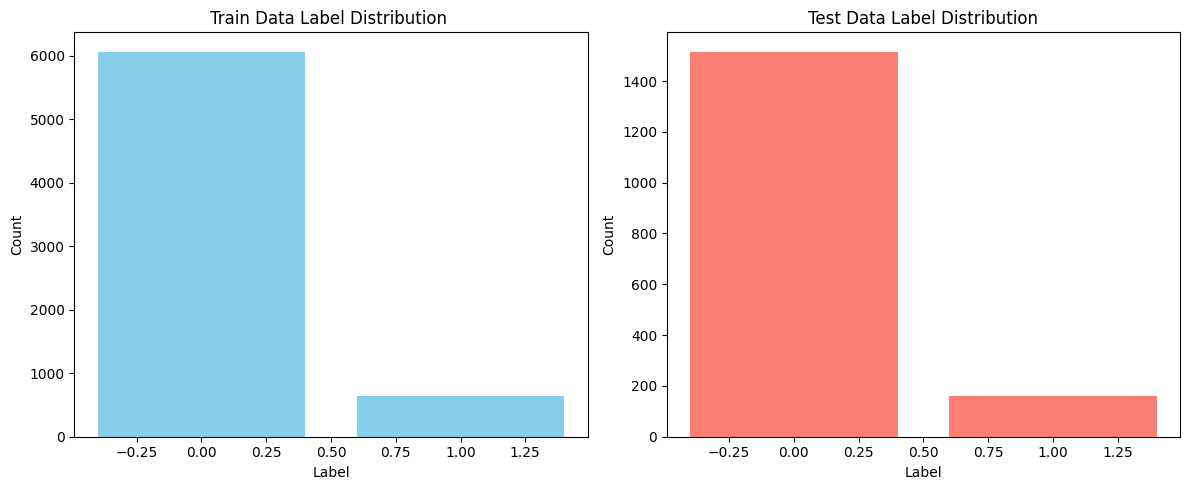

In [20]:
visualise_imbalance(internal_train_data, internal_test_data)

### Define evaluation/prediciton loops

In [11]:
def predict(model, loader: DataLoader, save_path: str = None):
  model.eval()

  predictions = []

  with torch.no_grad():
    for batch in loader:
      inputs = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)

      outputs = model(inputs, attention_mask=attention_mask)
      logits = outputs.logits

      preds = torch.argmax(logits, dim=1)
      predictions.extend(preds.cpu().numpy().tolist())
  
  if save_path is not None:
    with open(save_path, "w") as f:
      for prediction in predictions:
        f.write(f"{prediction}\n")

  return predictions

In [12]:
def evaluate(model, loader: DataLoader, plot_confusion: bool = True):
  y_true = []
  y_pred = []

  model.eval()
  with torch.no_grad():
      for batch in loader:
          inputs = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(inputs, attention_mask=attention_mask)
          logits = outputs.logits

          predictions = torch.argmax(logits, dim=1)

          y_true.extend(labels.cpu().numpy().tolist())
          y_pred.extend(predictions.cpu().numpy().tolist())

  # # Convert to numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  if plot_confusion:
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(6,5))
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
      plt.title("Confusion Matrix")
      plt.xlabel("Predicted Label")
      plt.ylabel("True Label")
      plt.show()

  return accuracy, f1

### Baseline Evaluation

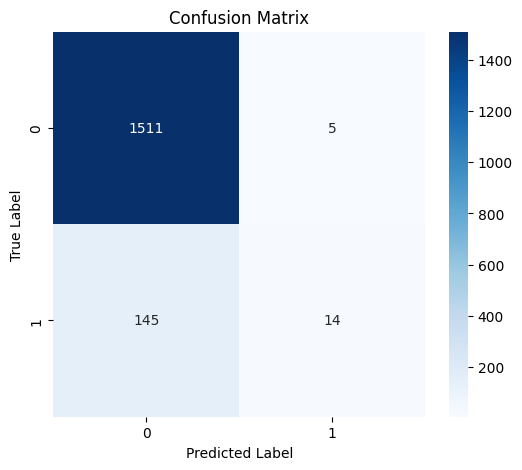

Test Accuracy: 0.910448
Test F1 Score: 0.157303


In [ ]:
model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

# approx 1min
test_acc, test_f1 = evaluate(model, test_loader, plot_confusion=True)

# Acc: 0.094925
# F1:  0.475086
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

### Define training loop

In [13]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses = None, title = ""):
  epochs = list(range(1, len(train_losses) + 1))
  fig, ax1 = plt.subplots(figsize=(8, 6))

  color_train = 'tab:blue'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Training Loss', color=color_train)
  ax1.plot(epochs, train_losses, color=color_train, marker='o', label='Training Loss')
  ax1.tick_params(axis='y', labelcolor=color_train)

  if val_losses is not None:
    # Create a second y-axis for the validation loss
    ax2 = ax1.twinx()
    color_val = 'tab:red'
    ax2.set_ylabel('Validation Loss', color=color_val)
    ax2.plot(epochs, val_losses, color=color_val, marker='o', label='Validation Loss')
    ax2.tick_params(axis='y', labelcolor=color_val)

  plt.title(title)
  fig.tight_layout()  # Adjust layout to ensure everything fits nicely
  plt.show()

def plot_f1_acc(f1s, accs, title = ""):
  epochs = list(range(1, len(f1s) + 1))
  fig, ax1 = plt.subplots(figsize=(8, 6))

  color_train = 'tab:blue'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Validation F1 Score', color=color_train)
  ax1.plot(epochs, f1s, color=color_train, marker='o', label='Validation F1 Score')
  ax1.tick_params(axis='y', labelcolor=color_train)

  # Create a second y-axis for the validation accuracy
  ax2 = ax1.twinx()
  color_val = 'tab:red'
  ax2.set_ylabel('Validation Accuracy', color=color_val)
  ax2.plot(epochs, accs, color=color_val, marker='o', label='Validation Accuracy')
  ax2.tick_params(axis='y', labelcolor=color_val)

  plt.title(title)
  fig.tight_layout()  # Adjust layout to ensure everything fits nicely
  plt.show()

In [14]:
from torch.amp import autocast, GradScaler

# {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
def finetune(
  model, 
  train_loader: DataLoader, 
  test_loader: DataLoader = None,
  num_epochs: int = 10, # optimal
  lr: float = 1e-5, # optimal
  patience: int = 2,
  plot: bool = True,
  plot_title: str = "",
  loss_function = None,
  plot_f1: bool = False
):

  best_val_loss = float("inf")
  epochs_no_improv = 0

  optimiser = optim.AdamW(model.parameters(), lr=lr)
  total_steps = len(train_loader) * num_epochs
  scheduler = get_linear_schedule_with_warmup(
    optimiser, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
  )

  train_losses = []
  val_losses = []

  if plot_f1:
    val_accs = []
    val_f1s = []

  scaler = GradScaler(device="cuda")

  timestamp = datetime.now().strftime("%H:%M:%S")
  print(f"{timestamp} - num_epochs = {num_epochs} | lr = {lr} | patience = {patience}")

  for epoch in range(num_epochs):
    model.train()
    total_loss: float = 0.0

    for batch in train_loader:
      optimiser.zero_grad()

      inputs = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      # Use `autocast` for mixed precision forward pass
      with autocast(device_type="cuda"):
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        if loss_function is None:
          loss = outputs.loss
        else:
          logits = outputs.logits
          loss = loss_function(logits, labels)

      scaler.scale(loss).backward()
      scaler.step(optimiser)
      scheduler.step()
      scaler.update()

      total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    if test_loader is not None:
      model.eval()
      total_val_loss = 0.0

      if plot_f1:
        y_true = []
        y_pred = []

      with torch.no_grad():
        for batch in test_loader:
          inputs = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          with autocast(device_type="cuda"):
            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            if plot_f1:
              logits = outputs.logits
              predictions = torch.argmax(logits, dim=1)

              y_true.extend(labels.cpu().numpy().tolist())
              y_pred.extend(predictions.cpu().numpy().tolist())
          total_val_loss += loss.item()

      y_true = np.array(y_true)
      y_pred = np.array(y_pred)

      accuracy = accuracy_score(y_true, y_pred)
      f1 = f1_score(y_true, y_pred)

      val_accs.append(accuracy)
      val_f1s.append(f1)

      avg_val_loss = total_val_loss / len(test_loader)
      val_losses.append(avg_val_loss)

      timestamp = datetime.now().strftime("%H:%M:%S")
      print(f"{timestamp} - Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_loss:.6f} | Validation Loss: {avg_val_loss:.6f} | Validation F1 Score: {f1:.6f}")

      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improv = 0
        best_model_state = model.state_dict()

      else:
        epochs_no_improv += 1
        if epochs_no_improv >= patience:
          print(f"Stopping at epoch {epoch + 1}...")
          break
    else:
      timestamp = datetime.now().strftime("%H:%M:%S")
      print(f"{timestamp} - Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_loss:.6f}")
      
  if plot:
    plot_losses(train_losses, val_losses, title=plot_title)
    
  if plot_f1 and test_loader is not None:
    plot_f1_acc(val_f1s, val_accs, title=plot_title)

### Baseline Finetune

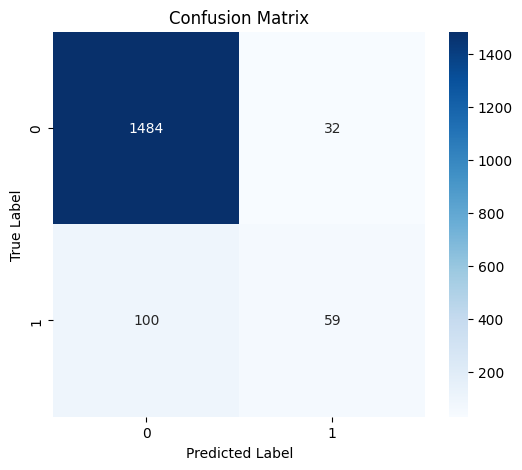

Test Accuracy: 0.921194
Test F1 Score: 0.472000


In [28]:
torch.cuda.empty_cache()

# model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)
model = RobertaForSequenceClassification.from_pretrained(basic_finetuned_dir).to(device)

# approx 5min per epoch
# finetune(model, train_loader, test_loader, num_epochs = 5, plot_title="Baseline (Post-Finetune)", plot_f1=True)

# approx 1min
test_acc, test_f1 = evaluate(model, test_loader, plot_confusion=True)

# Acc: 0.923591
# F1:  0.754404
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(basic_finetuned_dir)

### Reduce class imbalance via a weight loss function and/or weighted sampling

Weighted Loss:

In [15]:
import torch.nn as nn
def calculate_class_weights(data, num_labels = 2):
  labels = np.array([int(item["labels"]) for item in data])
  total = len(labels)

  counts = [np.sum(labels == class_label) for class_label in range(num_labels)]
  weights = [total / (2 * count) for count in counts]
  print(f"Class Weights: {[f"{label} : {weight:.4f}" for label, weight in enumerate(weights)]}")

  class_weights = torch.tensor(weights, dtype=torch.float).to(device)

  return class_weights

In [23]:
class_weights = calculate_class_weights(internal_train_data)
weighted_loss = nn.CrossEntropyLoss(weight=class_weights)

Class Weights: ['0 : 0.5523', '1 : 5.2756']


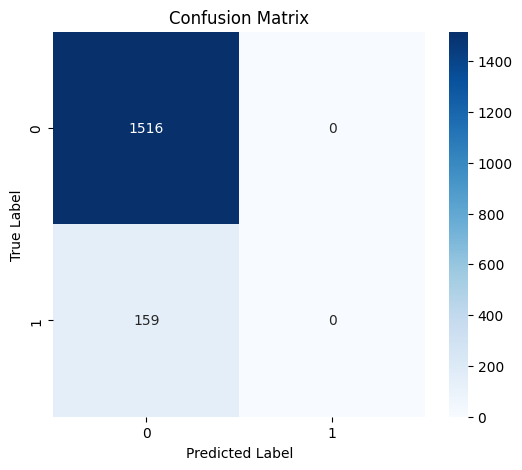

Test Accuracy: 0.905075
Test F1 Score: 0.000000


In [ ]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(
  model, 
  train_loader, 
  test_loader, 
  plot_f1=True, 
  plot_title="Weighted Loss Function to reduce Class Imbalance", 
  loss_function=weighted_loss,
  patience=5
)

test_acc, test_f1 = evaluate(model, test_loader, plot_confusion=True)

# Acc: ???
# F1:  0.766964
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(weighted_loss_dir)

Weighted Sampling:

In [16]:
from torch.utils.data import WeightedRandomSampler

def generate_sample_weights(data, class_weights):
  sample_weights = []
  for item in data:
    label = int(item["labels"])
    sample_weights.append(class_weights[label]) # using `weights` computed for weighted loss func

  return sample_weights

In [30]:
sample_weights = generate_sample_weights(internal_train_data, class_weights)

sampler = WeightedRandomSampler(sample_weights, num_samples=len(internal_train_data), replacement=True)
weighted_train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4)

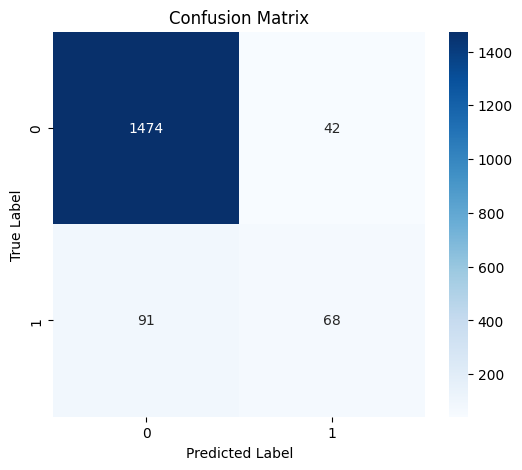

Test Accuracy: 0.920597
Test F1 Score: 0.505576


In [26]:
model = RobertaForSequenceClassification.from_pretrained(weighted_loss_dir).to(device)

test_acc, test_f1 = evaluate(model, test_loader, plot_confusion=True)
# Acc: 0.923591
# F1:  0.738289
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

02:22:12 - num_epochs = 10 | lr = 2e-05 | patience = 10
02:25:02 - Epoch 1/10 | Train Loss: 0.600037 | Validation Loss: 0.540960
02:27:53 - Epoch 2/10 | Train Loss: 0.290086 | Validation Loss: 0.288709
02:30:44 - Epoch 3/10 | Train Loss: 0.122439 | Validation Loss: 0.398220
02:33:35 - Epoch 4/10 | Train Loss: 0.069070 | Validation Loss: 0.393161
02:36:25 - Epoch 5/10 | Train Loss: 0.047067 | Validation Loss: 0.400706
02:39:16 - Epoch 6/10 | Train Loss: 0.039625 | Validation Loss: 0.337542
02:42:07 - Epoch 7/10 | Train Loss: 0.028024 | Validation Loss: 0.378660
02:44:58 - Epoch 8/10 | Train Loss: 0.012395 | Validation Loss: 0.460081
02:47:49 - Epoch 9/10 | Train Loss: 0.009873 | Validation Loss: 0.498185
02:50:39 - Epoch 10/10 | Train Loss: 0.010060 | Validation Loss: 0.524484


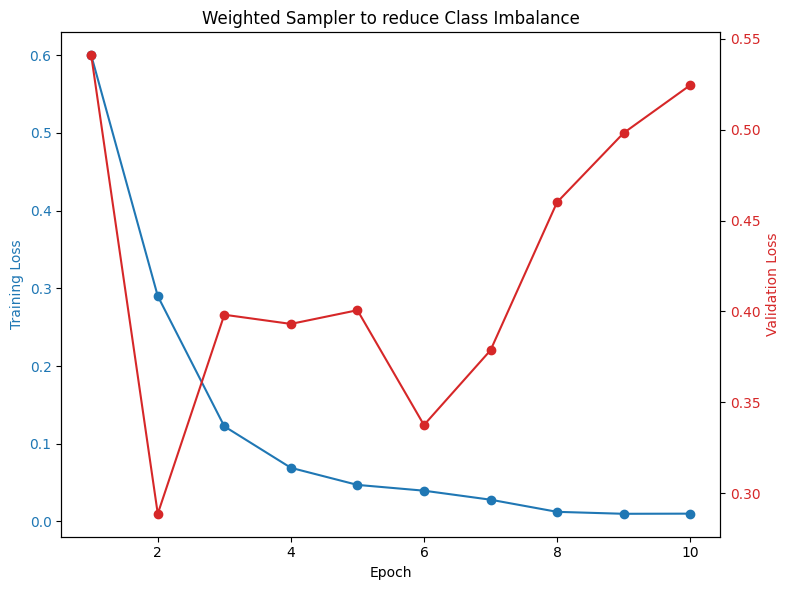

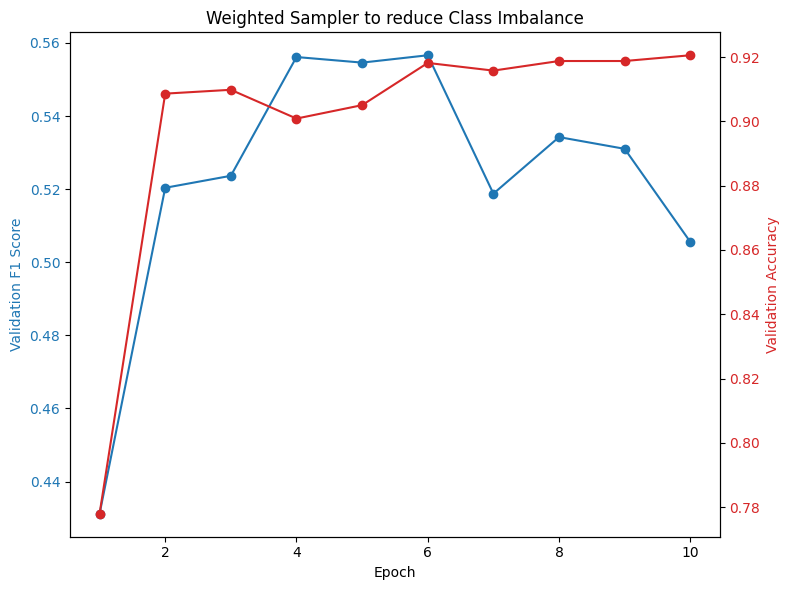

Test Accuracy: 0.920597
Test F1 Score: 0.505576


In [32]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(
  model, 
  weighted_train_loader, 
  test_loader, 
  plot_f1=True, 
  plot_title="Weighted Sampler to reduce Class Imbalance",
  patience=10
)

test_acc, test_f1 = evaluate(model, test_loader, plot_confusion=True)

# Acc: 0.923591
# F1:  0.738289
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(weighted_loss_dir)

Try with Both Weighted Sampling and Weighted Loss Function:

In [ ]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(
  model, 
  weighted_train_loader, 
  plot_title="Weighted Sampler and Weighted Loss Function to reduce Class Imbalance", 
  loss_function=weighted_loss,
  lr=1e-6,
  num_epochs=5
)

test_acc, test_f1 = evaluate(model, test_loader)

# Acc: ???
# F1:  ???
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(weighted_loss_sampler_dir)

02:20:43 - num_epochs = 5 | lr = 1e-06 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [ ]:

model = RobertaForSequenceClassification.from_pretrained(weighted_loss_sampler_dir).to(device)
test_acc, test_f1 = evaluate(model, test_loader)

# Acc: ???
# F1:  ???
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

### Data Augmentation to improve minority class representation

Synonym Replacement using `nlpaug`:

In [29]:
%pip install nlpaug
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.7 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
import nlpaug.augmenter.word as naw
import nltk
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger_eng')

# new hyperparams
# how many words to replace with synonyms
AUG_MIN = 1
AUG_MAX = 2
AUG_P = 0.3
N_SAMPLES = 5

augmenter = naw.SynonymAug(aug_src='wordnet', aug_min=AUG_MIN, aug_max=AUG_MAX, aug_p=AUG_P)

[nltk_data] Downloading package wordnet to /homes/rk1121/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /homes/rk1121/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [22]:
# test augmenter 

text = internal_train_data[15]["text"]
print(text)
augmented = augmenter.augment(text, n=N_SAMPLES)

print(augmented)

" A brawl broke out in the southern part of the camp in Calais between more than a hundred migrant minors from Eritrea and Afghanistan , " local authorities said .
['" A brawl broke out in the southern part of the camp in Calais between more than than a hundred migrant minors from Eritrea and Afghanistan, " local government said.', '" A brawl broke out in the southern part of the camp in Calais between more than a hundred migrant minors from Eritrea and Afghanistan, " local authorities say.', '" A brawl broke taboo in the southern part of the camp in Calais between more than a hundred migrant minors from Eritrea and Afghanistan, " local authorities articulate.', '" A brawl break out in the southern theatrical role of the camp in Calais between more than a hundred migrant minors from Eritrea and Afghanistan, " local authorities said.', '" A brawl broke out in the southern part of the camp in Calais between more than a hundred migrant minors from Eritrea and Afghanistan, " local authorit

doesn't seem particularly great, but the effect may be minimal on the meaning, so may stil reduce class imbalance

In [23]:
def augment_data(data, augmenter):
  augmented_samples = []
  for item in data:
    label = item["labels"]
    if int(label) == 1:
      original_text = item["text"]

      samples = augmenter.augment(original_text, n=N_SAMPLES)

      for sample in samples:
        tokenized = tokenize(sample, tokenizer)
        tokenized = { key: value.squeeze(0).clone() for key, value in tokenized.items() }
        tokenized["labels"] = 1
        tokenized["text"] = original_text
        augmented_samples.append(tokenized)

  return data + augmented_samples


In [23]:
train_data_augmented = augment_data(internal_train_data, augmenter)
train_dataset_augmented = DontPatronizeMeDataset(train_data_augmented)

--- Train ---
{0: 6065, 1: 2540}
{0: '70.48%', 1: '29.52%'}
--- Test ---
{0: 1516, 1: 159}
{0: '90.51%', 1: '9.49%'}


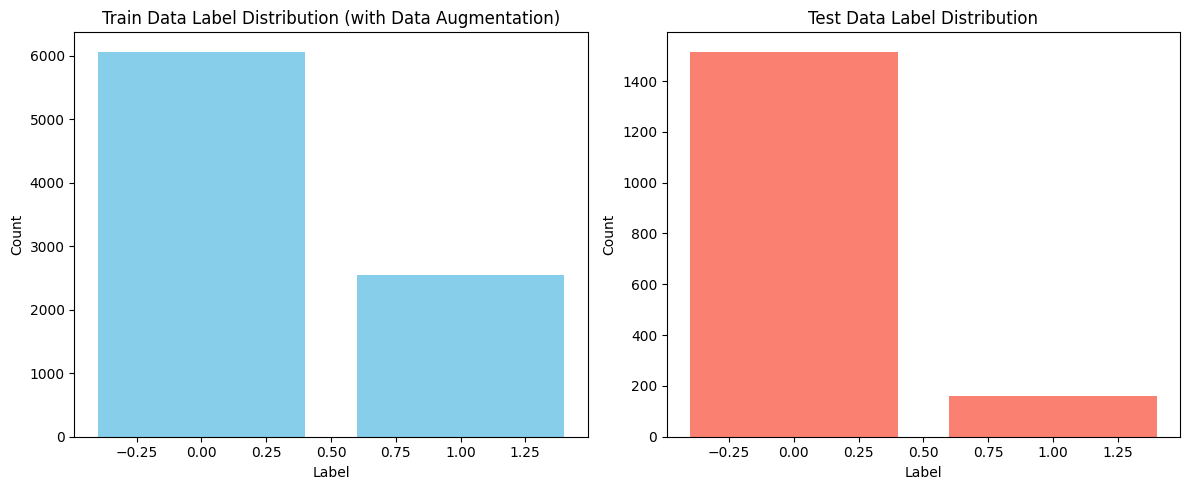

In [21]:
visualise_imbalance(train_data_augmented, internal_test_data, with_aug=True) 

In [22]:
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=16, shuffle=True, num_workers=4)

12:20:40 - num_epochs = 10 | lr = 1e-05 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


12:24:17 - Epoch 1/10 | Train Loss: 0.273822 | Validation Loss: 0.262681 | Validation F1 Score: 0.079096
12:27:54 - Epoch 2/10 | Train Loss: 0.153472 | Validation Loss: 0.214530 | Validation F1 Score: 0.505747
12:31:31 - Epoch 3/10 | Train Loss: 0.108604 | Validation Loss: 0.210304 | Validation F1 Score: 0.512635
12:35:08 - Epoch 4/10 | Train Loss: 0.051323 | Validation Loss: 0.360654 | Validation F1 Score: 0.514943
12:38:44 - Epoch 5/10 | Train Loss: 0.026996 | Validation Loss: 0.315782 | Validation F1 Score: 0.601266
Stopping at epoch 5...


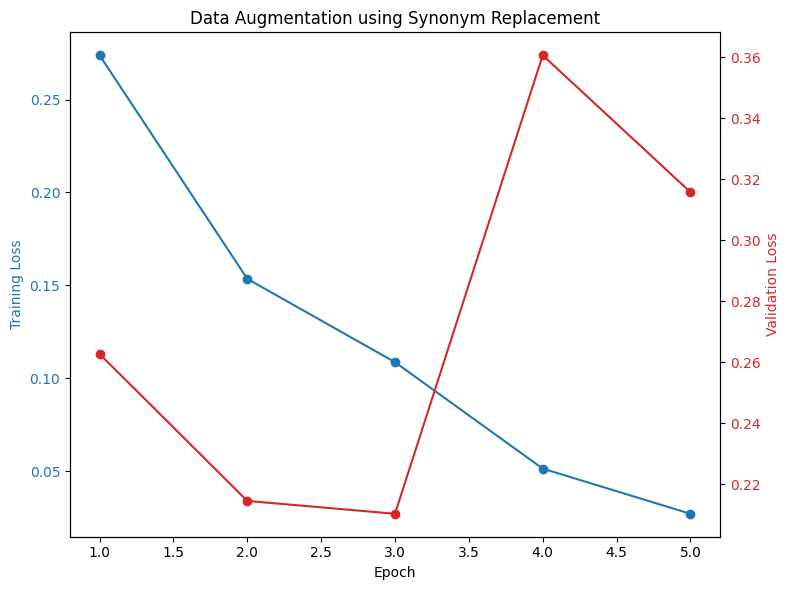

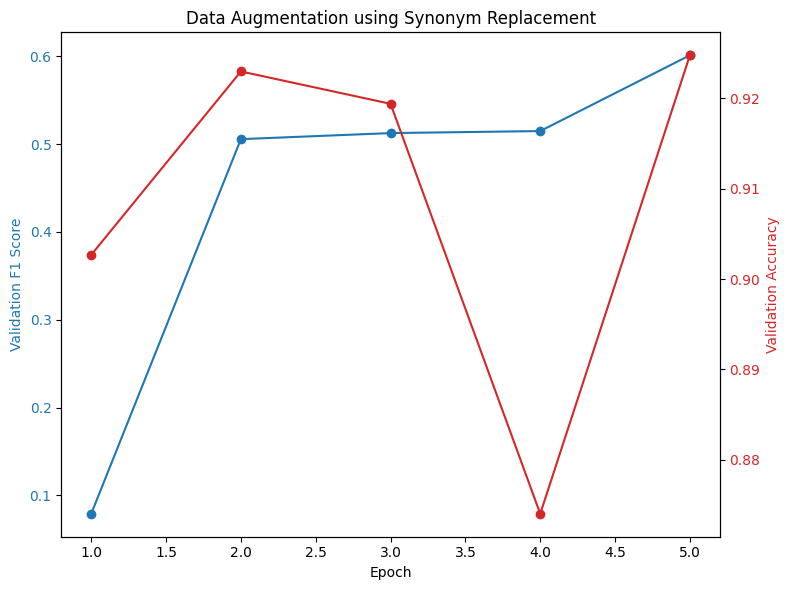

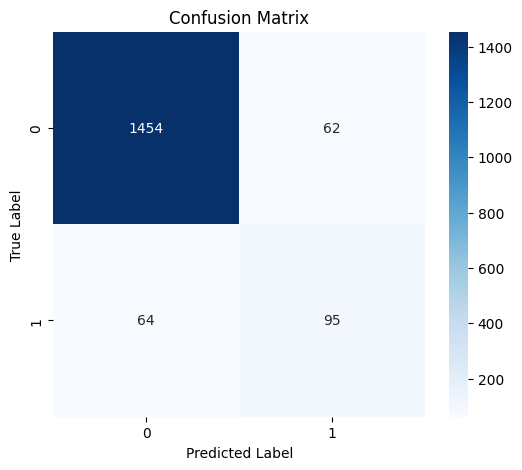

Test Accuracy: 0.924776
Test F1 Score: 0.601266


In [ ]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(
  model, 
  train_loader_augmented,
  test_loader,
  plot_f1=True, 
  plot_title="Data Augmentation using Synonym Replacement"
)

test_acc, test_f1 = evaluate(model, test_loader)

# Test Accuracy: 0.924776
# Test F1 Score: 0.601266
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(augmented_dir)

### Combining Weighted Loss Function, Weighted Sampling and Data Augmentation

In [25]:
import torch.nn as nn

train_labels = np.array([int(item["labels"]) for item in train_data_augmented])
total = len(train_labels)
num_classes = 2

counts = [np.sum(train_labels == class_label) for class_label in range(num_classes)]
weights = [total / (num_classes * count) for count in counts]
print(f"Class Weights: {[f"{label} : {weight:.4f}" for label, weight in enumerate(weights)]}")

class_weights = torch.tensor(weights, dtype=torch.float).to(device)
weighted_loss_augmented = nn.CrossEntropyLoss(weight=class_weights)

Class Weights: ['0 : 0.7094', '1 : 1.6939']


In [26]:
# seemed to cause massive overfitting when used alongside weighted loss

from torch.utils.data import WeightedRandomSampler

sample_weights = []
for item in train_data_augmented:
  label = int(item["labels"])
  sample_weights.append(weights[label]) # using `weights` computed for weighted loss func

sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_data_augmented), replacement=True)
weighted_train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=16, sampler=sampler, num_workers=4)

12:51:40 - num_epochs = 10 | lr = 1e-05 | patience = 6
12:55:17 - Epoch 1/10 | Train Loss: 0.273203 | Validation Loss: 0.233667 | Validation F1 Score: 0.520000
12:58:54 - Epoch 2/10 | Train Loss: 0.122040 | Validation Loss: 0.245888 | Validation F1 Score: 0.530612
13:02:31 - Epoch 3/10 | Train Loss: 0.076413 | Validation Loss: 0.294902 | Validation F1 Score: 0.435146
13:06:08 - Epoch 4/10 | Train Loss: 0.038178 | Validation Loss: 0.314861 | Validation F1 Score: 0.559006
13:09:45 - Epoch 5/10 | Train Loss: 0.026229 | Validation Loss: 0.319018 | Validation F1 Score: 0.534653
13:13:22 - Epoch 6/10 | Train Loss: 0.008539 | Validation Loss: 0.432921 | Validation F1 Score: 0.568690
13:16:59 - Epoch 7/10 | Train Loss: 0.006000 | Validation Loss: 0.443110 | Validation F1 Score: 0.540541
Stopping at epoch 7...


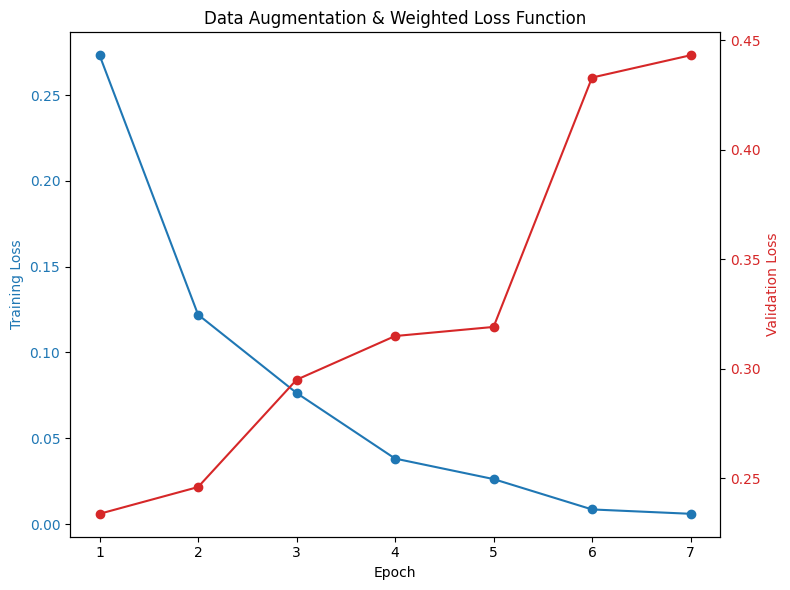

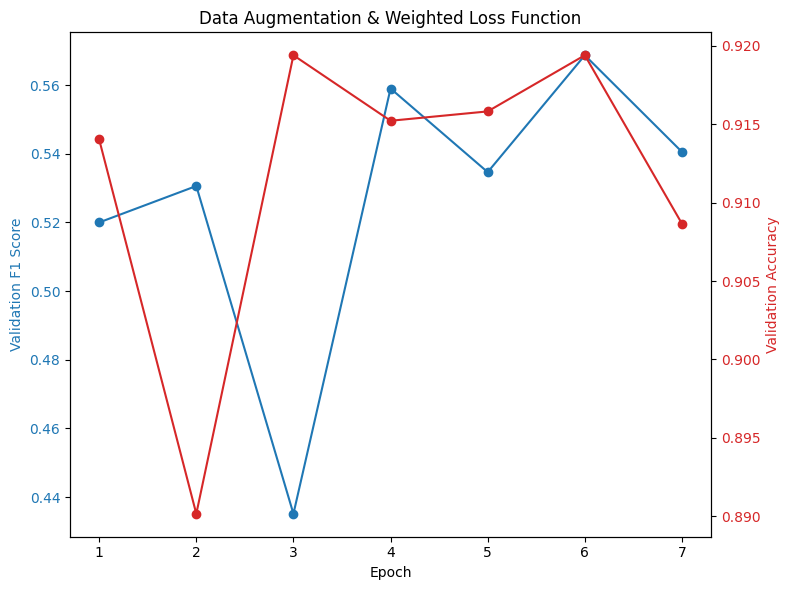

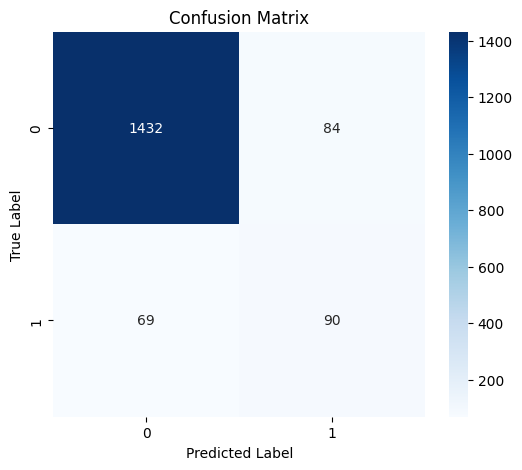

Test Accuracy: 0.908657
Test F1 Score: 0.540541


In [27]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(
  model, 
  # train_loader_augmented,
  weighted_train_loader_augmented, # use weighted sampling
  test_loader,
  plot_title="Data Augmentation & Weighted Loss Function", 
  plot_f1=True, 
  patience=6
  # loss_function=weighted_loss_augmented
)

test_acc, test_f1 = evaluate(model, test_loader)

# Acc: ???
# F1:  ???
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(combined_dir)

In [25]:
test_acc, test_f1 = evaluate(model, test_loader)

# Acc: ???
# F1:  ???
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(combined_dir)

Test Accuracy: 0.914040
Test F1 Score: 0.755602


### Downsampling the Majority Class

### Hyperparameter Search (via grid search)

In [24]:
import itertools

def hyperparam_search(
  train_data,
  val_loader,
  lrs = [1e-5, 2e-5, 1e-6, 5e-6],
  patiences = [1, 2, 5],
  epochs = [1, 3, 5, 10, 20],
  aug_mins = range(1, 3),
  aug_maxs = range(1, 8),
  aug_ps = [x / 10 for x in range(1, 5)],
  aug_samples = range(1, 5),
  with_aug = True,
  with_weighted_loss = False,
  with_weighted_sampling = True
):

  best_f1: float = 0.0
  best_params = None
  best_model_state = None

  param_grid = {
    "lr": lrs,
    # "patience": patiences,
    "num_epochs": epochs,
  }

  if with_aug:
    param_grid["aug_min"] = aug_mins
    param_grid["aug_max"] =  aug_maxs
    param_grid["aug_p"] =  aug_ps
    param_grid["aug_n"] =  aug_samples

  keys = list(param_grid.keys())

  for values in itertools.product(*param_grid.values()):
    torch.cuda.empty_cache()
    params = dict(zip(keys, values))

    aug_min = params.get("aug_min", 1)
    aug_max = params.get("aug_max", 3)
    if (aug_max < aug_min):
      continue
    
    lr = params.get("lr", 2e-5)
    patience = params.get("patience", 2)
    num_epochs = params.get("num_epochs", 10)

    aug_p = params.get("aug_p", 0.3)
    aug_n = params.get("aug_samples", 3)

    print("="*60)
    print(f"Testing hyperparams: {params}")
    print("="*60)

    if with_aug:
      augmenter = naw.SynonymAug(
          aug_src="wordnet",
          aug_min=aug_min,
          aug_max=aug_max,
          aug_p=aug_p
      )

      train_data = augment_data(train_data, augmenter) 

    train_dataset = DontPatronizeMeDataset(train_data)

    if with_weighted_loss or with_weighted_sampling:
      class_weights = calculate_class_weights(train_data)

    if with_weighted_sampling:
      sample_weights = generate_sample_weights(train_data, class_weights)
      sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_data), replacement=True)
      train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4)
    else:
      train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

    torch.cuda.empty_cache()

    model = RobertaForSequenceClassification.from_pretrained(raw_dir)
    model.to(device)

    if with_weighted_loss:
      loss_function = nn.CrossEntropyLoss(weight=class_weights)
      finetune(
        model=model,
        train_loader=train_loader,
        # test_loader=val_loader,
        num_epochs=num_epochs,
        lr=lr,
        patience=patience,
        plot=False,
        loss_function=loss_function
      )
    else:
      finetune(
        model=model,
        train_loader=train_loader,
        # test_loader=val_loader,
        num_epochs=num_epochs,
        lr=lr,
        patience=patience,
        plot=False
      )

    val_acc, val_f1 = evaluate(model, val_loader, plot_confusion=False)

    print(f"Validation Acc = {val_acc:.4f} | Validation F1 = {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_params = params
        best_model_state = model.state_dict()

  print("\n===== Hyperparameter Search Complete =====")
  print(f"Best F1: {best_f1:.4f}")
  print(f"Best Params: {best_params}")
    
  if best_model_state is not None:
    model.load_state_dict(best_model_state)
  return best_params, best_model_state, best_f1, model
      

Testing hyperparams: {'lr': 1e-05, 'patience': 1, 'num_epochs': 1}
03:37:53 - num_epochs = 1 | lr = 1e-05 | patience = 1
03:40:35 - Epoch 1/1 | Train Loss: 0.290677


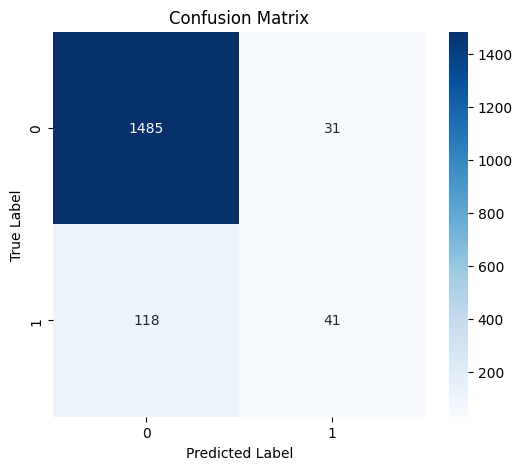

Validation Acc = 0.9110 | Validation F1 = 0.3550

===== Hyperparameter Search Complete =====
Best F1: 0.3550
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 1}
Testing hyperparams: {'lr': 1e-05, 'patience': 1, 'num_epochs': 3}
03:41:34 - num_epochs = 3 | lr = 1e-05 | patience = 1


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


03:44:16 - Epoch 1/3 | Train Loss: 0.278520
03:46:58 - Epoch 2/3 | Train Loss: 0.173146
03:49:40 - Epoch 3/3 | Train Loss: 0.106454


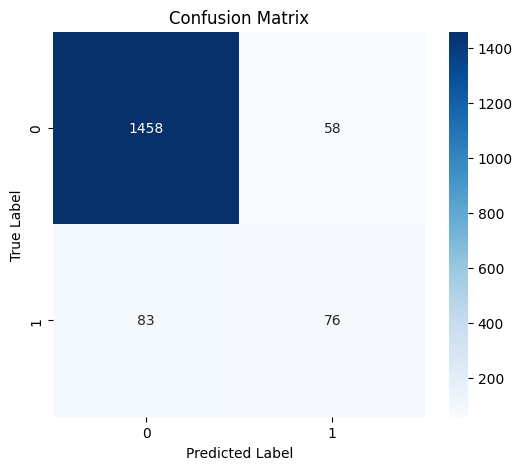

Validation Acc = 0.9158 | Validation F1 = 0.5188

===== Hyperparameter Search Complete =====
Best F1: 0.5188
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 3}
Testing hyperparams: {'lr': 1e-05, 'patience': 1, 'num_epochs': 5}
03:50:40 - num_epochs = 5 | lr = 1e-05 | patience = 1


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


03:53:22 - Epoch 1/5 | Train Loss: 0.283567
03:56:04 - Epoch 2/5 | Train Loss: 0.183241
03:58:46 - Epoch 3/5 | Train Loss: 0.102662
04:01:29 - Epoch 4/5 | Train Loss: 0.040866
04:04:11 - Epoch 5/5 | Train Loss: 0.013925


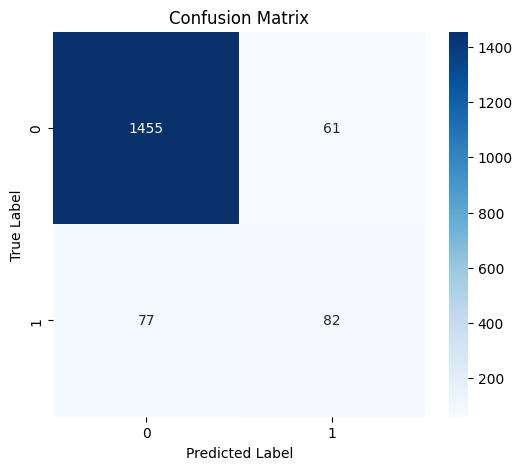

Validation Acc = 0.9176 | Validation F1 = 0.5430

===== Hyperparameter Search Complete =====
Best F1: 0.5430
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 5}
Testing hyperparams: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
04:05:11 - num_epochs = 10 | lr = 1e-05 | patience = 1
04:07:52 - Epoch 1/10 | Train Loss: 0.286522
04:10:34 - Epoch 2/10 | Train Loss: 0.187961
04:13:17 - Epoch 3/10 | Train Loss: 0.107296
04:15:59 - Epoch 4/10 | Train Loss: 0.044091
04:18:41 - Epoch 5/10 | Train Loss: 0.023151
04:21:23 - Epoch 6/10 | Train Loss: 0.010192
04:24:06 - Epoch 7/10 | Train Loss: 0.003817
04:26:48 - Epoch 8/10 | Train Loss: 0.003491
04:29:30 - Epoch 9/10 | Train Loss: 0.001139
04:32:12 - Epoch 10/10 | Train Loss: 0.000437


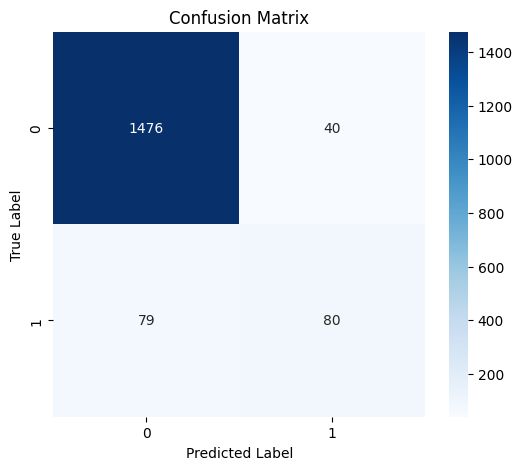

Validation Acc = 0.9290 | Validation F1 = 0.5735

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 1, 'num_epochs': 20}
04:33:12 - num_epochs = 20 | lr = 1e-05 | patience = 1
04:35:54 - Epoch 1/20 | Train Loss: 0.281657
04:38:36 - Epoch 2/20 | Train Loss: 0.199040
04:41:18 - Epoch 3/20 | Train Loss: 0.134082
04:44:00 - Epoch 4/20 | Train Loss: 0.065720
04:46:42 - Epoch 5/20 | Train Loss: 0.030033
04:49:25 - Epoch 6/20 | Train Loss: 0.020183
04:52:07 - Epoch 7/20 | Train Loss: 0.014499
04:54:49 - Epoch 8/20 | Train Loss: 0.005769
04:57:31 - Epoch 9/20 | Train Loss: 0.010743
05:00:13 - Epoch 10/20 | Train Loss: 0.007032
05:02:56 - Epoch 11/20 | Train Loss: 0.006041
05:05:38 - Epoch 12/20 | Train Loss: 0.003568
05:08:20 - Epoch 13/20 | Train Loss: 0.001357
05:11:02 - Epoch 14/20 | Train Loss: 0.000560
05:13:45 - Epoch 15/20 | Train Loss: 0.000307
05:16:27 - Epoch 16/20 | Tr

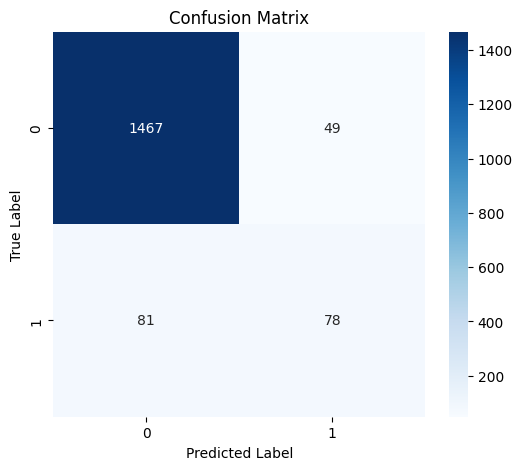

Validation Acc = 0.9224 | Validation F1 = 0.5455

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 2, 'num_epochs': 1}
05:28:16 - num_epochs = 1 | lr = 1e-05 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


05:30:57 - Epoch 1/1 | Train Loss: 0.269254


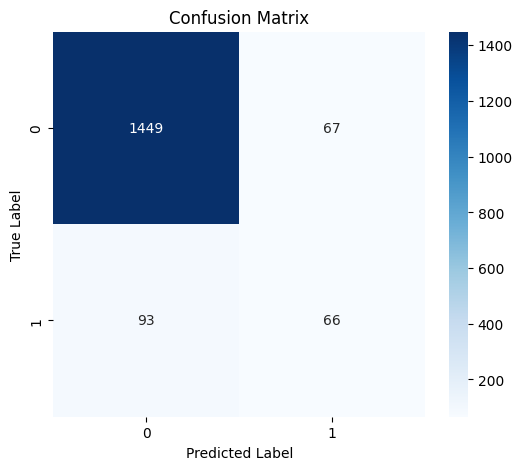

Validation Acc = 0.9045 | Validation F1 = 0.4521

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 2, 'num_epochs': 3}
05:31:57 - num_epochs = 3 | lr = 1e-05 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


05:34:38 - Epoch 1/3 | Train Loss: 0.313414
05:37:21 - Epoch 2/3 | Train Loss: 0.217873
05:40:03 - Epoch 3/3 | Train Loss: 0.156816


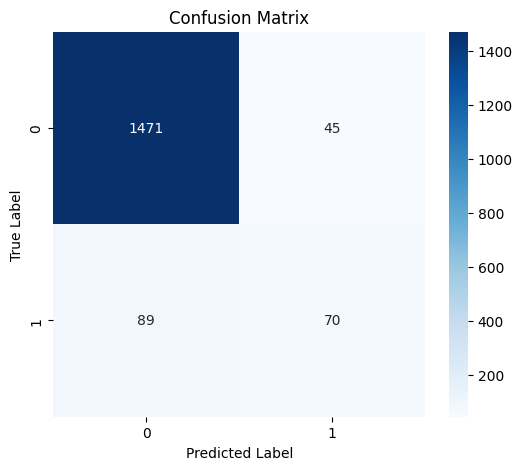

Validation Acc = 0.9200 | Validation F1 = 0.5109

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 2, 'num_epochs': 5}
05:41:02 - num_epochs = 5 | lr = 1e-05 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


05:43:44 - Epoch 1/5 | Train Loss: 0.293420
05:46:26 - Epoch 2/5 | Train Loss: 0.202217
05:49:08 - Epoch 3/5 | Train Loss: 0.138109
05:51:50 - Epoch 4/5 | Train Loss: 0.084706
05:54:32 - Epoch 5/5 | Train Loss: 0.043007


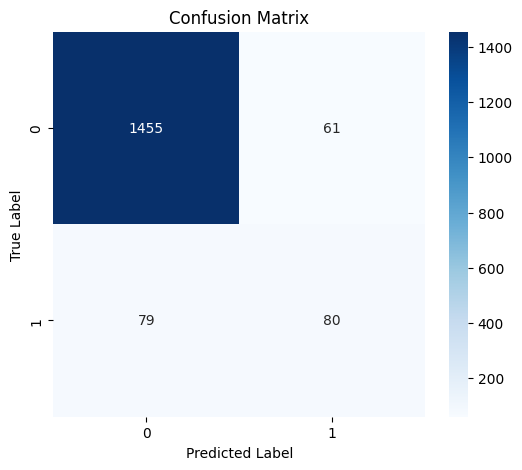

Validation Acc = 0.9164 | Validation F1 = 0.5333

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 2, 'num_epochs': 10}
05:55:32 - num_epochs = 10 | lr = 1e-05 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


05:58:14 - Epoch 1/10 | Train Loss: 0.273237
06:00:56 - Epoch 2/10 | Train Loss: 0.170960
06:03:38 - Epoch 3/10 | Train Loss: 0.092222
06:06:21 - Epoch 4/10 | Train Loss: 0.044069
06:09:03 - Epoch 5/10 | Train Loss: 0.021384
06:11:45 - Epoch 6/10 | Train Loss: 0.008679
06:14:27 - Epoch 7/10 | Train Loss: 0.004100
06:17:09 - Epoch 8/10 | Train Loss: 0.002911
06:19:52 - Epoch 9/10 | Train Loss: 0.004625
06:22:34 - Epoch 10/10 | Train Loss: 0.001627


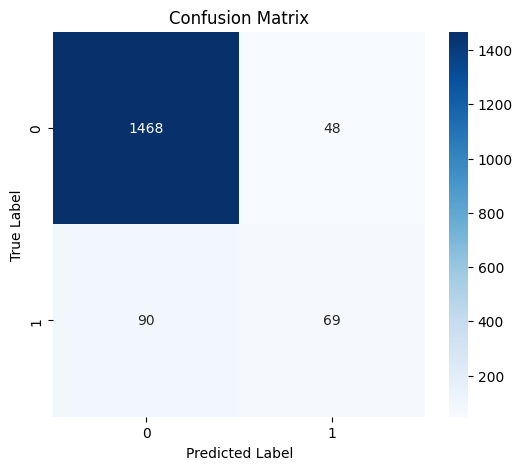

Validation Acc = 0.9176 | Validation F1 = 0.5000

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 2, 'num_epochs': 20}
06:23:34 - num_epochs = 20 | lr = 1e-05 | patience = 2
06:26:16 - Epoch 1/20 | Train Loss: 0.267666
06:28:58 - Epoch 2/20 | Train Loss: 0.167820
06:31:40 - Epoch 3/20 | Train Loss: 0.099846
06:34:22 - Epoch 4/20 | Train Loss: 0.045069
06:37:05 - Epoch 5/20 | Train Loss: 0.033182
06:39:47 - Epoch 6/20 | Train Loss: 0.016099
06:42:29 - Epoch 7/20 | Train Loss: 0.010394
06:45:11 - Epoch 8/20 | Train Loss: 0.010207
06:47:53 - Epoch 9/20 | Train Loss: 0.005358
06:50:35 - Epoch 10/20 | Train Loss: 0.005261
06:53:17 - Epoch 11/20 | Train Loss: 0.004543
06:56:00 - Epoch 12/20 | Train Loss: 0.002626
06:58:42 - Epoch 13/20 | Train Loss: 0.000347
07:01:24 - Epoch 14/20 | Train Loss: 0.004021
07:04:06 - Epoch 15/20 | Train Loss: 0.000172
07:06:48 - Epoch 16/20 | Tr

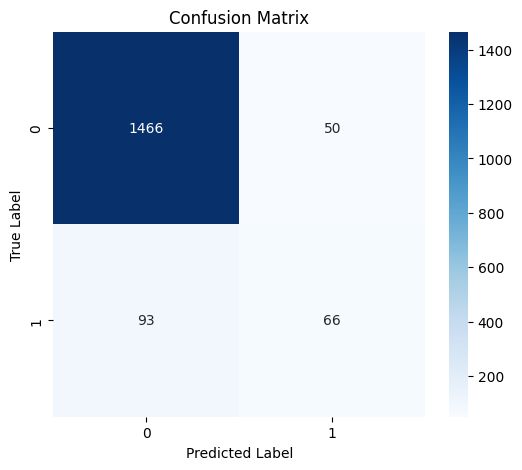

Validation Acc = 0.9146 | Validation F1 = 0.4800

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 5, 'num_epochs': 1}
07:18:37 - num_epochs = 1 | lr = 1e-05 | patience = 5
07:21:19 - Epoch 1/1 | Train Loss: 0.282657


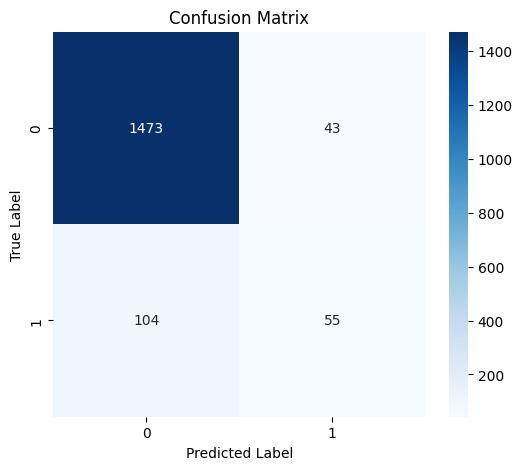

Validation Acc = 0.9122 | Validation F1 = 0.4280

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 5, 'num_epochs': 3}
07:22:19 - num_epochs = 3 | lr = 1e-05 | patience = 5


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


07:25:00 - Epoch 1/3 | Train Loss: 0.282224
07:27:42 - Epoch 2/3 | Train Loss: 0.184143
07:30:25 - Epoch 3/3 | Train Loss: 0.114319


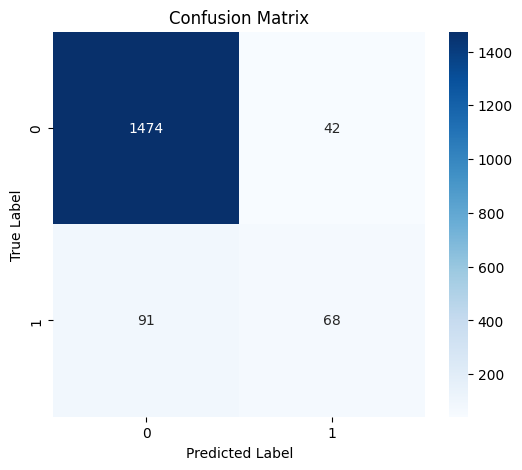

Validation Acc = 0.9206 | Validation F1 = 0.5056

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 5, 'num_epochs': 5}
07:31:25 - num_epochs = 5 | lr = 1e-05 | patience = 5
07:34:06 - Epoch 1/5 | Train Loss: 0.279819
07:36:48 - Epoch 2/5 | Train Loss: 0.173517
07:39:31 - Epoch 3/5 | Train Loss: 0.104345
07:42:13 - Epoch 4/5 | Train Loss: 0.051756
07:44:55 - Epoch 5/5 | Train Loss: 0.020700


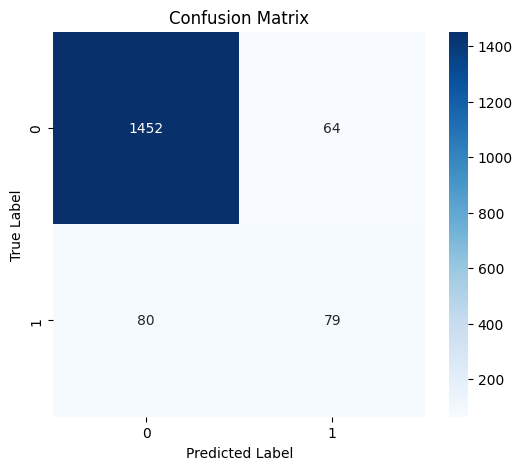

Validation Acc = 0.9140 | Validation F1 = 0.5232

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 5, 'num_epochs': 10}
07:45:55 - num_epochs = 10 | lr = 1e-05 | patience = 5
07:48:36 - Epoch 1/10 | Train Loss: 0.283659
07:51:18 - Epoch 2/10 | Train Loss: 0.184939
07:54:01 - Epoch 3/10 | Train Loss: 0.111944
07:56:43 - Epoch 4/10 | Train Loss: 0.056610
07:59:25 - Epoch 5/10 | Train Loss: 0.021258
08:02:07 - Epoch 6/10 | Train Loss: 0.011759
08:04:49 - Epoch 7/10 | Train Loss: 0.005869
08:07:31 - Epoch 8/10 | Train Loss: 0.003926
08:10:14 - Epoch 9/10 | Train Loss: 0.002691
08:12:56 - Epoch 10/10 | Train Loss: 0.001741


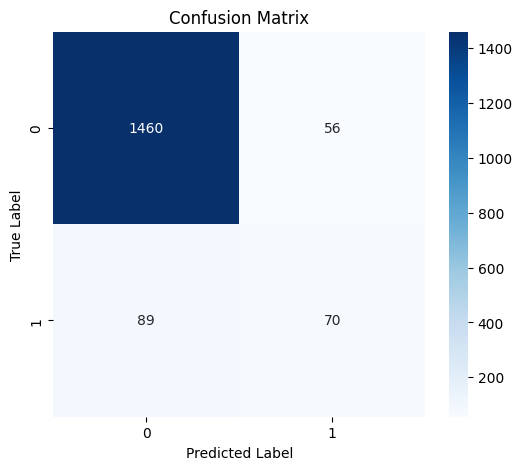

Validation Acc = 0.9134 | Validation F1 = 0.4912

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 1e-05, 'patience': 5, 'num_epochs': 20}
08:13:56 - num_epochs = 20 | lr = 1e-05 | patience = 5


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


08:16:37 - Epoch 1/20 | Train Loss: 0.332429
08:19:19 - Epoch 2/20 | Train Loss: 0.318202
08:22:01 - Epoch 3/20 | Train Loss: 0.318333
08:24:44 - Epoch 4/20 | Train Loss: 0.316776
08:27:26 - Epoch 5/20 | Train Loss: 0.317456
08:30:08 - Epoch 6/20 | Train Loss: 0.317308
08:32:50 - Epoch 7/20 | Train Loss: 0.316650
08:35:32 - Epoch 8/20 | Train Loss: 0.316013
08:38:15 - Epoch 9/20 | Train Loss: 0.314688
08:40:57 - Epoch 10/20 | Train Loss: 0.317857
08:43:39 - Epoch 11/20 | Train Loss: 0.316196
08:46:21 - Epoch 12/20 | Train Loss: 0.314426
08:49:03 - Epoch 13/20 | Train Loss: 0.314097
08:51:45 - Epoch 14/20 | Train Loss: 0.314043
08:54:27 - Epoch 15/20 | Train Loss: 0.316150
08:57:10 - Epoch 16/20 | Train Loss: 0.304903
08:59:52 - Epoch 17/20 | Train Loss: 0.293039
09:02:34 - Epoch 18/20 | Train Loss: 0.273556
09:05:16 - Epoch 19/20 | Train Loss: 0.252629
09:07:59 - Epoch 20/20 | Train Loss: 0.245591


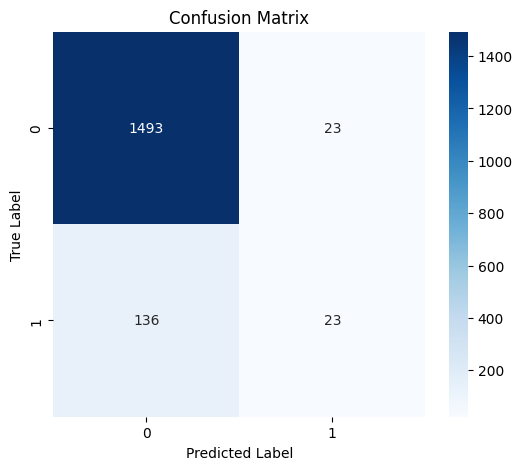

Validation Acc = 0.9051 | Validation F1 = 0.2244

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 1, 'num_epochs': 1}
09:08:59 - num_epochs = 1 | lr = 2e-05 | patience = 1


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


09:11:40 - Epoch 1/1 | Train Loss: 0.256539


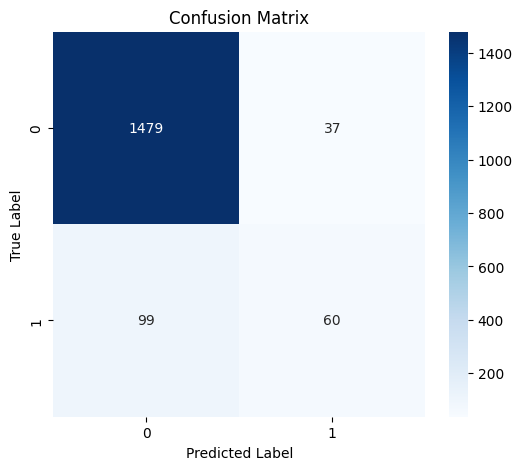

Validation Acc = 0.9188 | Validation F1 = 0.4688

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 1, 'num_epochs': 3}
09:12:40 - num_epochs = 3 | lr = 2e-05 | patience = 1
09:15:22 - Epoch 1/3 | Train Loss: 0.333390
09:18:04 - Epoch 2/3 | Train Loss: 0.318604
09:20:46 - Epoch 3/3 | Train Loss: 0.316504


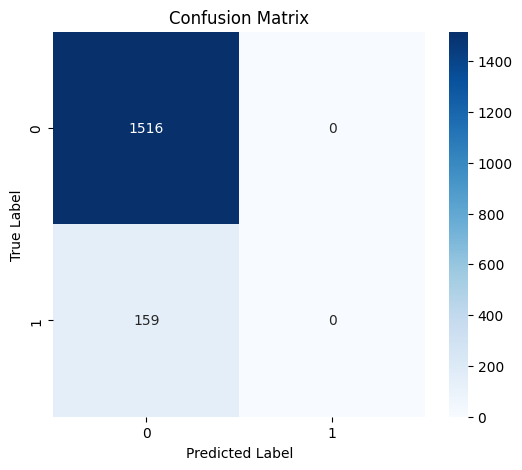

Validation Acc = 0.9051 | Validation F1 = 0.0000

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 1, 'num_epochs': 5}
09:21:46 - num_epochs = 5 | lr = 2e-05 | patience = 1
09:24:28 - Epoch 1/5 | Train Loss: 0.276231
09:27:10 - Epoch 2/5 | Train Loss: 0.183068
09:29:52 - Epoch 3/5 | Train Loss: 0.103141
09:32:34 - Epoch 4/5 | Train Loss: 0.045365
09:35:17 - Epoch 5/5 | Train Loss: 0.012350


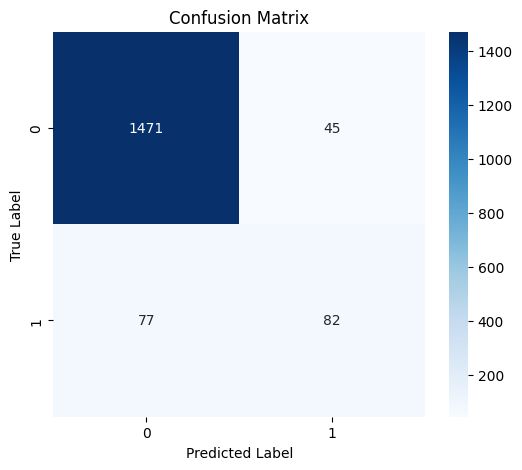

Validation Acc = 0.9272 | Validation F1 = 0.5734

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 1, 'num_epochs': 10}
09:36:16 - num_epochs = 10 | lr = 2e-05 | patience = 1


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


09:38:58 - Epoch 1/10 | Train Loss: 0.269999
09:41:41 - Epoch 2/10 | Train Loss: 0.185043
09:44:23 - Epoch 3/10 | Train Loss: 0.106719
09:47:05 - Epoch 4/10 | Train Loss: 0.044705
09:49:47 - Epoch 5/10 | Train Loss: 0.024625
09:52:29 - Epoch 6/10 | Train Loss: 0.012410
09:55:12 - Epoch 7/10 | Train Loss: 0.003928
09:57:54 - Epoch 8/10 | Train Loss: 0.004207
10:00:36 - Epoch 9/10 | Train Loss: 0.002158
10:03:18 - Epoch 10/10 | Train Loss: 0.002188


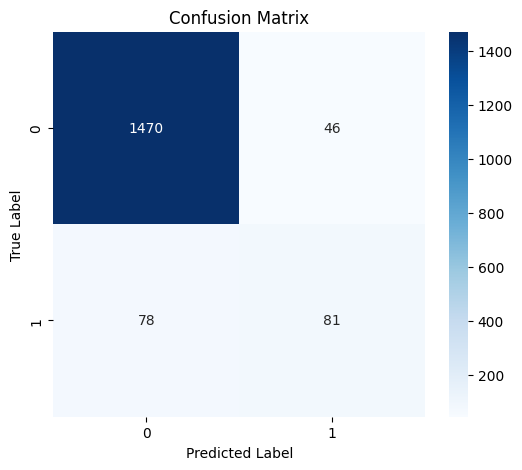

Validation Acc = 0.9260 | Validation F1 = 0.5664

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 1, 'num_epochs': 20}
10:04:18 - num_epochs = 20 | lr = 2e-05 | patience = 1
10:07:00 - Epoch 1/20 | Train Loss: 0.285490
10:09:42 - Epoch 2/20 | Train Loss: 0.209832
10:12:24 - Epoch 3/20 | Train Loss: 0.147953
10:15:06 - Epoch 4/20 | Train Loss: 0.094990
10:17:49 - Epoch 5/20 | Train Loss: 0.049214
10:20:31 - Epoch 6/20 | Train Loss: 0.024901
10:23:13 - Epoch 7/20 | Train Loss: 0.025030
10:25:55 - Epoch 8/20 | Train Loss: 0.010715
10:28:37 - Epoch 9/20 | Train Loss: 0.018062
10:31:19 - Epoch 10/20 | Train Loss: 0.007195
10:34:02 - Epoch 11/20 | Train Loss: 0.002646
10:36:44 - Epoch 12/20 | Train Loss: 0.004264
10:39:26 - Epoch 13/20 | Train Loss: 0.003073
10:42:08 - Epoch 14/20 | Train Loss: 0.000827
10:44:50 - Epoch 15/20 | Train Loss: 0.000876
10:47:32 - Epoch 16/20 | Tr

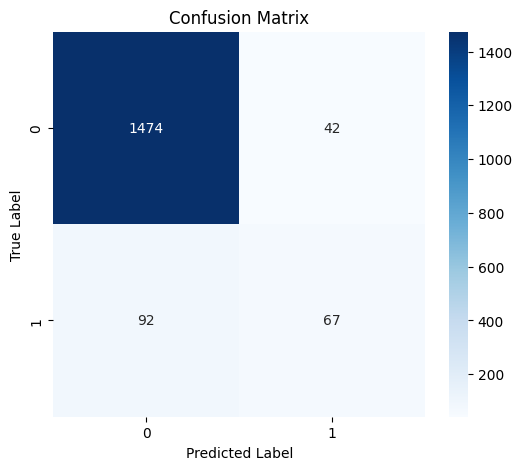

Validation Acc = 0.9200 | Validation F1 = 0.5000

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 2, 'num_epochs': 1}
10:59:21 - num_epochs = 1 | lr = 2e-05 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


11:02:02 - Epoch 1/1 | Train Loss: 0.289931


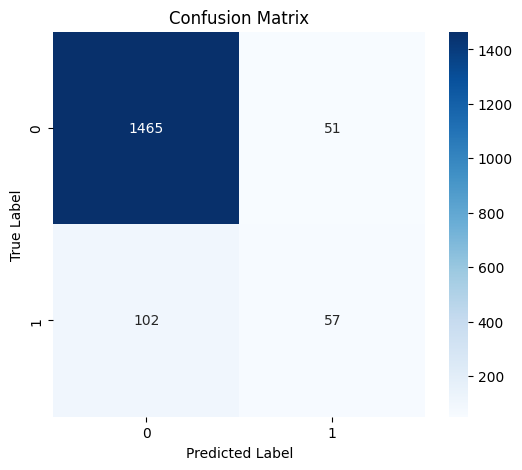

Validation Acc = 0.9087 | Validation F1 = 0.4270

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 2, 'num_epochs': 3}
11:03:02 - num_epochs = 3 | lr = 2e-05 | patience = 2
11:05:44 - Epoch 1/3 | Train Loss: 0.291320
11:08:26 - Epoch 2/3 | Train Loss: 0.190101
11:11:08 - Epoch 3/3 | Train Loss: 0.106900


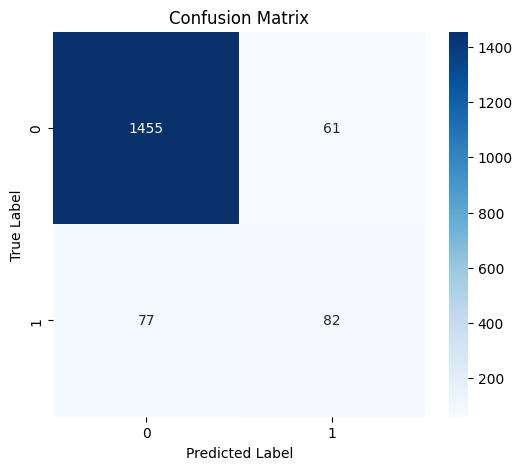

Validation Acc = 0.9176 | Validation F1 = 0.5430

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 2, 'num_epochs': 5}
11:12:08 - num_epochs = 5 | lr = 2e-05 | patience = 2
11:14:50 - Epoch 1/5 | Train Loss: 0.322789
11:17:32 - Epoch 2/5 | Train Loss: 0.225557
11:20:14 - Epoch 3/5 | Train Loss: 0.144594
11:22:56 - Epoch 4/5 | Train Loss: 0.058264
11:25:39 - Epoch 5/5 | Train Loss: 0.016080


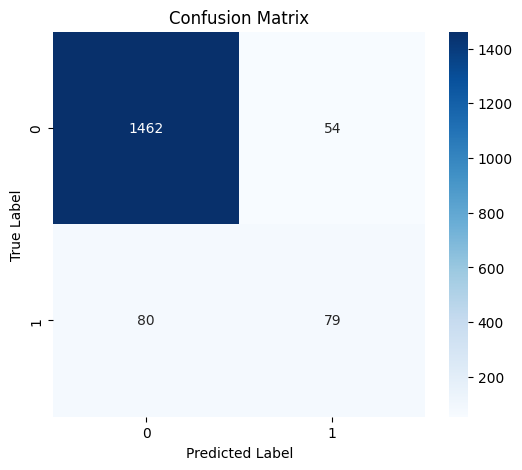

Validation Acc = 0.9200 | Validation F1 = 0.5411

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 2, 'num_epochs': 10}
11:26:39 - num_epochs = 10 | lr = 2e-05 | patience = 2
11:29:20 - Epoch 1/10 | Train Loss: 0.328935
11:32:02 - Epoch 2/10 | Train Loss: 0.319769
11:34:44 - Epoch 3/10 | Train Loss: 0.307429
11:37:27 - Epoch 4/10 | Train Loss: 0.308152
11:40:09 - Epoch 5/10 | Train Loss: 0.318567
11:42:51 - Epoch 6/10 | Train Loss: 0.312796
11:45:33 - Epoch 7/10 | Train Loss: 0.260005
11:48:15 - Epoch 8/10 | Train Loss: 0.204185
11:50:57 - Epoch 9/10 | Train Loss: 0.156228
11:53:39 - Epoch 10/10 | Train Loss: 0.122411


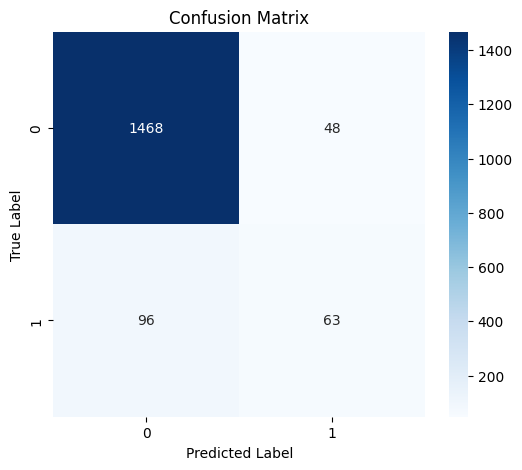

Validation Acc = 0.9140 | Validation F1 = 0.4667

===== Hyperparameter Search Complete =====
Best F1: 0.5735
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 10}
Testing hyperparams: {'lr': 2e-05, 'patience': 2, 'num_epochs': 20}
11:54:39 - num_epochs = 20 | lr = 2e-05 | patience = 2
11:57:21 - Epoch 1/20 | Train Loss: 0.265192
12:00:03 - Epoch 2/20 | Train Loss: 0.176185
12:02:46 - Epoch 3/20 | Train Loss: 0.100798
12:05:28 - Epoch 4/20 | Train Loss: 0.056514
12:08:10 - Epoch 5/20 | Train Loss: 0.028812


KeyboardInterrupt: 

In [22]:
torch.cuda.empty_cache()
params, model_state, f1, model = hyperparam_search(
  internal_train_data, 
  test_loader,
  with_aug=False,
  with_weighted_loss=False
)

In [25]:
torch.cuda.empty_cache()
params, model_state, f1, model = hyperparam_search(
  internal_train_data, 
  test_loader,
  epochs= [5],
  lrs = [1e-5],
  patiences=[1, 2, 5],
  aug_mins = range(1, 3),
  aug_maxs = [3, 5],
  aug_ps = [x / 10 for x in range(1, 5)],
  aug_samples = range(1, 5),
)

model.to(device)
model.save_pretrained(optimal_dir)

Testing hyperparams: {'lr': 1e-05, 'num_epochs': 5, 'aug_min': 1, 'aug_max': 3, 'aug_p': 0.1, 'aug_n': 1}
Class Weights: ['0 : 0.7094', '1 : 1.6939']
14:03:05 - num_epochs = 5 | lr = 1e-05 | patience = 2
14:06:33 - Epoch 1/5 | Train Loss: 0.266367
14:10:02 - Epoch 2/5 | Train Loss: 0.120868
14:13:30 - Epoch 3/5 | Train Loss: 0.056302
14:16:58 - Epoch 4/5 | Train Loss: 0.032384
14:20:26 - Epoch 5/5 | Train Loss: 0.015903
Validation Acc = 0.9194 | Validation F1 = 0.5161
Testing hyperparams: {'lr': 1e-05, 'num_epochs': 5, 'aug_min': 1, 'aug_max': 3, 'aug_p': 0.1, 'aug_n': 2}
Class Weights: ['0 : 1.3376', '1 : 0.7985']
14:21:39 - num_epochs = 5 | lr = 1e-05 | patience = 2
14:28:11 - Epoch 1/5 | Train Loss: 0.154117
14:34:43 - Epoch 2/5 | Train Loss: 0.078595
14:41:16 - Epoch 3/5 | Train Loss: 0.049868
14:47:49 - Epoch 4/5 | Train Loss: 0.027643
14:54:22 - Epoch 5/5 | Train Loss: 0.018693
Validation Acc = 0.9212 | Validation F1 = 0.5111
Testing hyperparams: {'lr': 1e-05, 'num_epochs': 5, 'a

KeyboardInterrupt: 

In [24]:
def optimal_model(
  train_data,
  val_loader,
  lr = 1e-5,
  patience = 5,
  num_epochs = 10,
  aug_min = 1,
  aug_max = 5,
  aug_p = 0.3,
  aug_n = 3,
  with_aug = True,
  with_weighted_loss = False,
  with_weighted_sampling = True

):
  if with_aug:
    augmenter = naw.SynonymAug(
        aug_src="wordnet",
        aug_min=aug_min,
        aug_max=aug_max,
        aug_p=aug_p
    )

    train_data = augment_data(train_data, augmenter) 

  train_dataset = DontPatronizeMeDataset(train_data)

  if with_weighted_loss or with_weighted_sampling:
    class_weights = calculate_class_weights(train_data)

  if with_weighted_sampling:
    sample_weights = generate_sample_weights(train_data, class_weights)
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_data), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4)
  else:
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

  torch.cuda.empty_cache()

  model = RobertaForSequenceClassification.from_pretrained(raw_dir)
  model.to(device)

  if with_weighted_loss:
    loss_function = nn.CrossEntropyLoss(weight=class_weights)
    finetune(
      model=model,
      train_loader=train_loader,
      test_loader=val_loader,
      num_epochs=num_epochs,
      lr=lr,
      patience=patience,
      plot=True,
      plot_f1=True,
      loss_function=loss_function
    )
  else:
    finetune(
      model=model,
      train_loader=train_loader,
      test_loader=val_loader,
      num_epochs=num_epochs,
      lr=lr,
      patience=patience,
      plot_f1=True,
      plot=True
    )

  val_acc, val_f1 = evaluate(model, val_loader, plot_confusion=True)

  print(f"Validation Acc = {val_acc:.4f} | Validation F1 = {val_f1:.4f}")

  return model, val_acc, val_f1 

Class Weights: ['0 : 0.8141', '1 : 1.2959']
16:51:09 - num_epochs = 10 | lr = 1e-05 | patience = 5
16:55:17 - Epoch 1/10 | Train Loss: 0.228254 | Validation Loss: 0.222892 | Validation F1 Score: 0.396761
16:59:24 - Epoch 2/10 | Train Loss: 0.106289 | Validation Loss: 0.287223 | Validation F1 Score: 0.520885
17:03:32 - Epoch 3/10 | Train Loss: 0.066465 | Validation Loss: 0.270681 | Validation F1 Score: 0.505747
17:07:40 - Epoch 4/10 | Train Loss: 0.038619 | Validation Loss: 0.316172 | Validation F1 Score: 0.515901
17:11:48 - Epoch 5/10 | Train Loss: 0.024184 | Validation Loss: 0.315508 | Validation F1 Score: 0.526667
17:15:55 - Epoch 6/10 | Train Loss: 0.012631 | Validation Loss: 0.331396 | Validation F1 Score: 0.565916
Stopping at epoch 6...


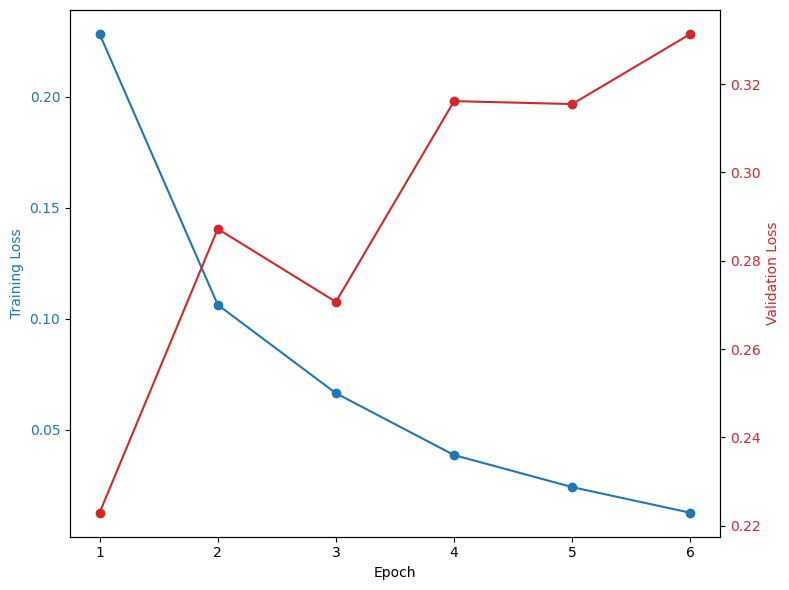

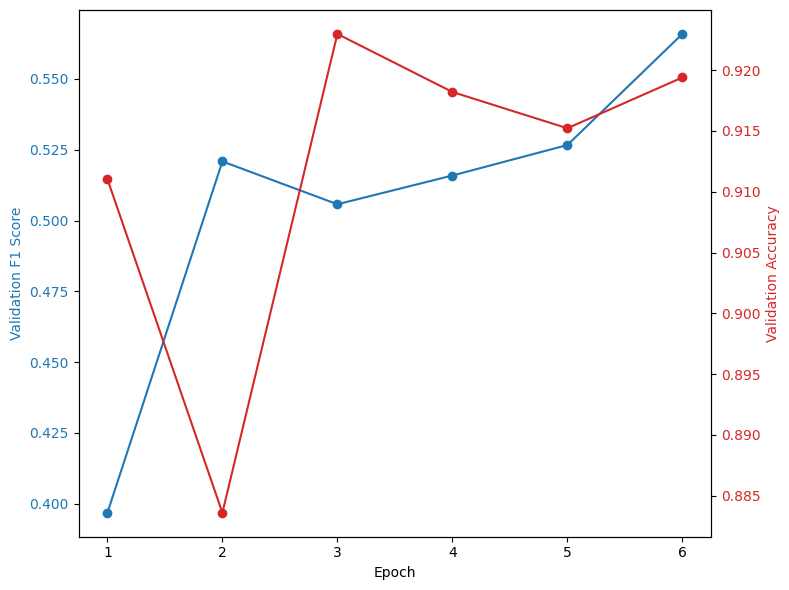

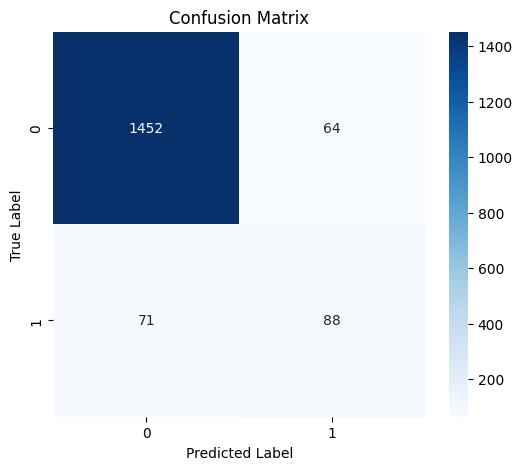

Validation Acc = 0.9194 | Validation F1 = 0.5659


In [25]:
model, val_acc, val_f1 = optimal_model(
  internal_train_data, 
  test_loader,
  lr = 1e-5,
  patience = 5,
  num_epochs = 10,
  aug_min = 1,
  aug_max = 5,
  aug_p = 0.3,
  aug_n = 3,
  with_aug = True,
  with_weighted_loss = False,
  with_weighted_sampling = True
)

In [27]:
model.save_pretrained(final_dir)

### Evaluate the final model using the official-dev set

In [29]:
official_dev_dataset = DontPatronizeMeDataset(official_dev_data, tokenizer=tokenizer, max_length=128)
official_dev_loader = DataLoader(official_dev_dataset, batch_size=16, shuffle=False, num_workers=4)

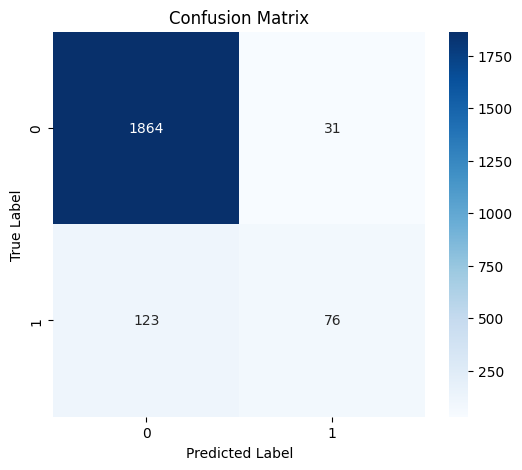

Test Accuracy: 0.926457
Test F1 Score: 0.496732


In [30]:
model = RobertaForSequenceClassification.from_pretrained(basic_finetuned_dir).to(device)

# approx 1min
test_acc, test_f1 = evaluate(model, official_dev_loader)

# Test Accuracy: ???
# Test F1 Score: ???
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

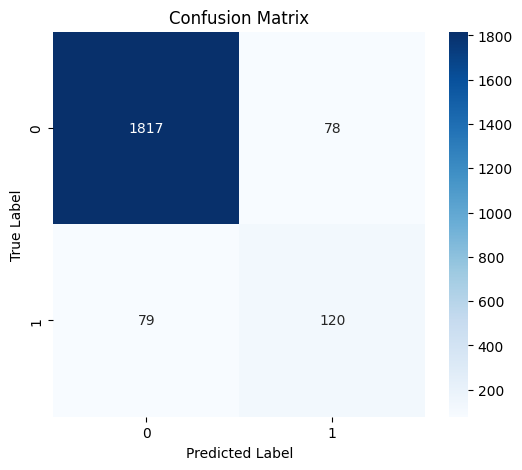

Test Accuracy: 0.925024
Test F1 Score: 0.604534


In [31]:
model = RobertaForSequenceClassification.from_pretrained(final_dir).to(device)

# approx 1min
test_acc, test_f1 = evaluate(model, official_dev_loader)

# Test Accuracy: 0.914040
# Test F1 Score: 0.573460
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

### Load test data

In [32]:
TEST_DATA_PATH = "data/task4_test.tsv"

column_names = ["par_id", "art_id", "keyword", "country", "text"]
official_test_data = pd.read_csv(TEST_DATA_PATH, sep="\t", header=None, names=column_names)

print("Test Data shape:", official_test_data.shape)

# print(test_text_data.head())

official_test_dataset = DontPatronizeMeDataset(official_test_data, tokenizer, max_length=128, has_label=False)
offical_test_loader = DataLoader(official_test_dataset, batch_size=16, shuffle=False, num_workers=4)


Test Data shape: (3832, 5)


In [33]:
model = RobertaForSequenceClassification.from_pretrained(final_dir).to(device)

In [34]:
print("Generating predictions for Dev...")
predict(model, official_dev_loader, save_path="dev.txt")

Generating predictions for Dev...


[0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [35]:
print("Generating predictions for Test...")
predict(model, offical_test_loader, save_path="test.txt")

Generating predictions for Test...


[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
